In [1]:
!pip install transformers
!pip install wget

# Imports

In [44]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import json
import os
from collections import defaultdict
import ast
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from matplotlib import pyplot as plt

# Loading data and some stats

In [3]:
movies_data = pd.read_csv("movies_metadata.csv", usecols=['id', 'overview', 'production_countries', 'original_language', 'revenue', 'budget', 'genres'])

box_office_data = pd.read_csv("box_office_collections.csv").drop(columns=['Movie Name', 'imdbId'])

<ipython-input-3-fb742290e1da>:3: DtypeWarning: Columns (13,69,92,96,100,104,105,106,107,110,113,115,120,121,122,123,124,126,127,128,129,130,131) have mixed types. Specify dtype option on import or set low_memory=False.
  box_office_data = pd.read_csv("box_office_collections.csv").drop(columns=['Movie Name', 'imdbId'])


In [4]:
# Number of rows with missing id
print(movies_data['id'].isna().sum())
print(box_office_data['id'].isna().sum())
print("NaN revenues: ", movies_data['revenue'].isna().sum())
print("0 revenues: ", movies_data['revenue'].eq(0).sum())

print("Revenue range: [", movies_data['revenue'].min(), ", ", movies_data['revenue'].max(), "]")

# Create bins for revenue, first bin with NaN, second with 0s and the rest with equal width
step = movies_data['revenue'].max() / 10
bins = [-0.1, 0.1] + [step * i for i in range(1, 11)]
revenue_bins = pd.cut(movies_data['revenue'], bins)
print("Revenue bins: ", revenue_bins.value_counts())

0
0
NaN revenues:  6
0 revenues:  38052
Revenue range: [ 0.0 ,  2787965087.0 ]
Revenue bins:  (-0.1, 0.1]                     38052
(0.1, 278796508.7]               6966
(278796508.7, 557593017.4]        299
(557593017.4, 836389526.1]         87
(836389526.1, 1115186034.8]        40
(1115186034.8, 1393982543.5]        9
(1393982543.5, 1672779052.2]        4
(1672779052.2, 1951575560.9]        1
(1951575560.9, 2230372069.6]        1
(2509168578.3, 2787965087.0]        1
(2230372069.6, 2509168578.3]        0
Name: revenue, dtype: int64


In [5]:
# Budget bins
print("NaN budgets: ", movies_data['budget'].isna().sum())

numerical_budgets = movies_data['budget'][movies_data['budget'].str.isnumeric()].astype(int)

print("Numerical budgets: ", numerical_budgets.shape[0])
print("Budget range: [", numerical_budgets.min(), ", ", numerical_budgets.max(), "]")

step = numerical_budgets.max() / 10
bins = [-0.1, 0.1] + [step * i for i in range(1, 11)]
budget_bins = pd.cut(numerical_budgets, bins)
print("Budget bins: ", budget_bins.value_counts())

NaN budgets:  0
Numerical budgets:  45463
Budget range: [ 0 ,  380000000 ]
Budget bins:  (-0.1, 0.1]                   36573
(0.1, 38000000.0]              7379
(38000000.0, 76000000.0]        928
(76000000.0, 114000000.0]       298
(114000000.0, 152000000.0]      163
(152000000.0, 190000000.0]       64
(190000000.0, 228000000.0]       35
(228000000.0, 266000000.0]       19
(266000000.0, 304000000.0]        3
(342000000.0, 380000000.0]        1
(304000000.0, 342000000.0]        0
Name: budget, dtype: int64


# Data cleaning

## IDs

In [6]:
print("Shape before ", movies_data.shape)
movies_data = movies_data[movies_data['id'].str.isnumeric()]
movies_data['id'] = movies_data['id'].astype(int)
print("Shape after dropping rows with invalid ids: ", movies_data.shape)

Shape before  (45466, 7)
Shape after dropping rows with invalid ids:  (45463, 7)


## Budget

In [7]:
# Add columns budget_unknown
movies_data['budget'] = pd.to_numeric(movies_data['budget'], errors='coerce', downcast='float')
movies_data['budget_unknown'] = movies_data['budget'].apply(lambda x: 1 if x == 0.0 else 0)
movies_data['budget_100M'] = movies_data['budget'] / 1e8
print("Number of non-zero budgets: ", movies_data['budget'].ne(0).sum())
print("Number of unknown budgets: ", movies_data['budget_unknown'].sum())

Number of non-zero budgets:  8890
Number of unknown budgets:  36573


In [8]:
# Stats for budget_100M
print("Range of budget_100M: [", movies_data['budget_100M'].min(), ", ", movies_data['budget_100M'].max(), "]")
print("Mean: ", movies_data['budget_100M'].mean())
print("Median: ", movies_data['budget_100M'].median())
print("Std: ", movies_data['budget_100M'].std())

Range of budget_100M: [ 0.0 ,  3.8 ]
Mean:  0.042245788134746935
Median:  0.0
Std:  0.17424132634341216


## Revenue

In [9]:
print("Shape before ", movies_data.shape)
movies_data.dropna(subset=['revenue'], inplace=True)
movies_data['revenue_100M'] = movies_data['revenue'] / 1e8
print("Shape after dropping rows with NaN revenues and appending revenue_100M column: ", movies_data.shape)

Shape before  (45463, 9)
Shape after dropping rows with NaN revenues and appending revenue_100M column:  (45460, 10)


In [10]:
# Stats for revenue_100M
print("Range of revenue_100M: [", movies_data['revenue_100M'].min(), ", ", movies_data['revenue_100M'].max(), "]")
print("Mean: ", movies_data['revenue_100M'].mean())
print("Median: ", movies_data['revenue_100M'].median())
print("Std: ", movies_data['revenue_100M'].std())

Range of revenue_100M: [ 0.0 ,  27.87965087 ]
Mean:  0.11209348539265288
Median:  0.0
Std:  0.6433224674065112


## Overview

In [11]:
movies_data['overview'] = movies_data['overview'].fillna('')

## Country-wise revenues

In [12]:
print("Shape before ", box_office_data.shape)
box_office_data[box_office_data.columns[1:]] = box_office_data[box_office_data.columns[1:]].replace('[\$,]', '', regex=True).astype(float)
# Append revenue_ to all column names except id
new_cols = [(col, 'revenue_'+col) for col in box_office_data.columns[1:]]
box_office_data.rename(columns=dict(new_cols), inplace=True)

print("Shape after ", box_office_data.shape)

Shape before  (10076, 130)
Shape after  (10076, 130)


## Movies metadata after initial cleanup

In [13]:
print("Shape: ", movies_data.shape)
print("dtypes:", movies_data.dtypes)


Shape:  (45460, 10)
dtypes: budget                  float64
genres                   object
id                        int64
original_language        object
overview                 object
production_countries     object
revenue                 float64
budget_unknown            int64
budget_100M             float64
revenue_100M            float64
dtype: object


In [14]:
movies_data.head()

,budget,genres,id,original_language,overview,production_countries,revenue,budget_unknown,budget_100M,revenue_100M
0,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,"Led by Woody, Andy's toys live happily in his ...","[{'iso_3166_1': 'US', 'name': 'United States o...",373554033.0,0,0.30,3.735540
1,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,When siblings Judy and Peter discover an encha...,"[{'iso_3166_1': 'US', 'name': 'United States o...",262797249.0,0,0.65,2.627972
2,0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,A family wedding reignites the ancient feud be...,"[{'iso_3166_1': 'US', 'name': 'United States o...",0.0,1,0.00,0.000000
3,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,"Cheated on, mistreated and stepped on, the wom...","[{'iso_3166_1': 'US', 'name': 'United States o...",81452156.0,0,0.16,0.814522
4,0.0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Just when George Banks has recovered from his ...,"[{'iso_3166_1': 'US', 'name': 'United States o...",76578911.0,1,0.00,0.765789


## Country-wise revenue after initial cleanup

In [15]:
print("Shape: ", box_office_data.shape)
print("dtypes:", box_office_data.dtypes)

Shape:  (10076, 130)
dtypes: id                        int64
revenue_Argentina       float64
revenue_Aruba           float64
revenue_Australia       float64
revenue_Austria         float64
                         ...   
revenue_E/W Africa      float64
revenue_Laos            float64
revenue_Bosnia          float64
revenue_Soviet Union    float64
revenue_Malta           float64
Length: 130, dtype: object


In [16]:
box_office_data.head()


,id,revenue_Argentina,revenue_Aruba,revenue_Australia,revenue_Austria,revenue_Bahrain,revenue_Belgium,revenue_Bolivia,revenue_Brazil,revenue_Bulgaria,...,revenue_Guatemala,revenue_Netherlands Antilles,revenue_North Macedonia,revenue_South Africa/Nigeria,revenue_Switzerland (French/Italian),revenue_E/W Africa,revenue_Laos,revenue_Bosnia,revenue_Soviet Union,revenue_Malta
0,133185,NaN,NaN,1203589.0,482703.0,NaN,2444798.0,4083.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,133195,360654.0,NaN,1750077.0,479263.0,335561.0,596815.0,68107.0,1051166.0,104255.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,133199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,133219,654232.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,133225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1667.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Join with country-wise revenue data

In [17]:
merged_data = pd.merge(movies_data, box_office_data, how='left', on='id')
print("Shape after merge: ", merged_data.shape)
merged_data.head()

Shape after merge:  (45460, 139)


,budget,genres,id,original_language,overview,production_countries,revenue,budget_unknown,budget_100M,revenue_100M,...,revenue_Guatemala,revenue_Netherlands Antilles,revenue_North Macedonia,revenue_South Africa/Nigeria,revenue_Switzerland (French/Italian),revenue_E/W Africa,revenue_Laos,revenue_Bosnia,revenue_Soviet Union,revenue_Malta
0,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,"Led by Woody, Andy's toys live happily in his ...","[{'iso_3166_1': 'US', 'name': 'United States o...",373554033.0,0,0.30,3.735540,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,When siblings Judy and Peter discover an encha...,"[{'iso_3166_1': 'US', 'name': 'United States o...",262797249.0,0,0.65,2.627972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,A family wedding reignites the ancient feud be...,"[{'iso_3166_1': 'US', 'name': 'United States o...",0.0,1,0.00,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,"Cheated on, mistreated and stepped on, the wom...","[{'iso_3166_1': 'US', 'name': 'United States o...",81452156.0,0,0.16,0.814522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Just when George Banks has recovered from his ...,"[{'iso_3166_1': 'US', 'name': 'United States o...",76578911.0,1,0.00,0.765789,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Stats for country-wise revenue columns with mostly missing values

In [18]:
# For each column, count the number of rows with NaN values. Also calculate the number of rows with NaN values in any and all columns.

print("Rows with any Na values: ", merged_data.isna().any(axis=1).sum())
print("Rows with all Na values: ", merged_data.isna().all(axis=1).sum())

x = merged_data.isna().sum()

# Print cols with only a few non-null values
print("Fewer than 10 non-null values ", len(x[x > merged_data.shape[0] - 10]))
print("Fewer than 50 non-null values ", len(x[x > merged_data.shape[0] - 50]))
print("Fewer than 100 non-null values ", len(x[x > merged_data.shape[0] - 100]))
print("Fewer than 500 non-null values ", len(x[x > merged_data.shape[0] - 500]))
print("Fewer than 1000 non-null values ", len(x[x > merged_data.shape[0] - 1000]))

non_na = merged_data.notna().sum()
print("Columns with more than 500 non-null values ", len(non_na[non_na > 500]))
print(non_na[non_na > 500])

print("Count of Na values in each column:")
pd.set_option("display.max_rows", 200)
print(x)
pd.reset_option("display.max_rows")

Rows with any Na values:  45460
Rows with all Na values:  0
Fewer than 10 non-null values  37
Fewer than 50 non-null values  54
Fewer than 100 non-null values  67
Fewer than 500 non-null values  112
Fewer than 1000 non-null values  129
Columns with more than 500 non-null values  27
budget                    45460
genres                    45460
id                        45460
original_language         45449
overview                  45460
production_countries      45460
revenue                   45460
budget_unknown            45460
budget_100M               45460
revenue_100M              45460
revenue_Argentina           540
revenue_Australia           821
revenue_Austria             550
revenue_Belgium             506
revenue_Domestic            693
revenue_France              779
revenue_Germany             696
revenue_Italy               676
revenue_Mexico              660
revenue_Netherlands         517
revenue_New Zealand         735
revenue_Portugal            550
revenue_Russi

### Remove revenue columns with less than 500 non-null values

In [19]:
# Pick countries with more than 500 country-wise revenue rows
countries = x[x > merged_data.shape[0] - 500].index.tolist()
merged_data.drop(columns=countries, inplace=True)
print("Shape after dropping columns with fewer than 1000 non-null values ", merged_data.shape)
merged_data.head()

Shape after dropping columns with fewer than 1000 non-null values  (45460, 27)


,budget,genres,id,original_language,overview,production_countries,revenue,budget_unknown,budget_100M,revenue_100M,...,revenue_Italy,revenue_Mexico,revenue_Netherlands,revenue_New Zealand,revenue_Portugal,revenue_Russia/CIS,revenue_South Korea,revenue_Spain,revenue_Taiwan,revenue_United Kingdom
0,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,"Led by Woody, Andy's toys live happily in his ...","[{'iso_3166_1': 'US', 'name': 'United States o...",373554033.0,0,0.30,3.735540,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,When siblings Judy and Peter discover an encha...,"[{'iso_3166_1': 'US', 'name': 'United States o...",262797249.0,0,0.65,2.627972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,A family wedding reignites the ancient feud be...,"[{'iso_3166_1': 'US', 'name': 'United States o...",0.0,1,0.00,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,"Cheated on, mistreated and stepped on, the wom...","[{'iso_3166_1': 'US', 'name': 'United States o...",81452156.0,0,0.16,0.814522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Just when George Banks has recovered from his ...,"[{'iso_3166_1': 'US', 'name': 'United States o...",76578911.0,1,0.00,0.765789,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Multi-hot encode Production Countries (skipped for now)

In [20]:
# print("All production_countries values: ", merged_data['production_countries'].unique())

# # Read the array inside each production_countries cell as a list, and convert it into a list of country_ids, where country_id is the index in dictionary built from all unique countries encountered in the list in each cell of production_countries column
# def get_country_isos(production_country):
#     country_isos = []
#     for country in ast.literal_eval(production_country):
#         country_isos.append(country['iso_3166_1'])
#     return country_isos

# merged_data['production_countries_isos'] = merged_data['production_countries'].apply(get_country_isos)

# # multi-hot encode the production_countries column
# mlb = MultiLabelBinarizer()
# mlb.fit(merged_data['production_countries_isos'])
# print("Total number of classes: ", len(mlb.classes_))
# print("Classes: ", mlb.classes_)

# multi_hot_encoded_countries = mlb.transform(merged_data['production_countries_isos'])
# # Create a dataframe with the multi-hot encoded columns, where column names are 'production_country_' + mlb.classes_
# multi_hot_encoded_countries_df = pd.DataFrame(multi_hot_encoded_countries, columns=['production_country_' + country for country in mlb.classes_])

# merged_data = pd.concat([merged_data, multi_hot_encoded_countries_df], axis=1)
# merged_data.drop(columns=['production_countries', 'production_countries_isos'], inplace=True)
# merged_data.head()

## One-hot encode languages

In [21]:
print("All original_language values: ", merged_data['original_language'].unique())

# Convert original_language to one-hot encoding, including NaN values
merged_data = pd.get_dummies(merged_data, columns=['original_language'], dummy_na=True)
merged_data.head()

All original_language values:  ['en' 'fr' 'zh' 'it' 'fa' 'nl' 'de' 'cn' 'ar' 'es' 'ru' 'sv' 'ja' 'ko'
 'sr' 'bn' 'he' 'pt' 'wo' 'ro' 'hu' 'cy' 'vi' 'cs' 'da' 'no' 'nb' 'pl'
 'el' 'sh' 'xx' 'mk' 'bo' 'ca' 'fi' 'th' 'sk' 'bs' 'hi' 'tr' 'is' 'ps'
 'ab' 'eo' 'ka' 'mn' 'bm' 'zu' 'uk' 'af' 'la' 'et' 'ku' 'fy' 'lv' 'ta'
 'sl' 'tl' 'ur' 'rw' 'id' 'bg' 'mr' 'lt' 'kk' 'ms' 'sq' nan 'qu' 'te' 'am'
 'jv' 'tg' 'ml' 'hr' 'lo' 'ay' 'kn' 'eu' 'ne' 'pa' 'ky' 'gl' 'uz' 'sm'
 'mt' 'hy' 'iu' 'lb' 'si']


,budget,genres,id,overview,production_countries,revenue,budget_unknown,budget_100M,revenue_100M,revenue_Argentina,...,original_language_tr,original_language_uk,original_language_ur,original_language_uz,original_language_vi,original_language_wo,original_language_xx,original_language_zh,original_language_zu,original_language_nan
0,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,"Led by Woody, Andy's toys live happily in his ...","[{'iso_3166_1': 'US', 'name': 'United States o...",373554033.0,0,0.30,3.735540,NaN,...,0,0,0,0,0,0,0,0,0,0
1,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,When siblings Judy and Peter discover an encha...,"[{'iso_3166_1': 'US', 'name': 'United States o...",262797249.0,0,0.65,2.627972,NaN,...,0,0,0,0,0,0,0,0,0,0
2,0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,A family wedding reignites the ancient feud be...,"[{'iso_3166_1': 'US', 'name': 'United States o...",0.0,1,0.00,0.000000,NaN,...,0,0,0,0,0,0,0,0,0,0
3,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,"Cheated on, mistreated and stepped on, the wom...","[{'iso_3166_1': 'US', 'name': 'United States o...",81452156.0,0,0.16,0.814522,NaN,...,0,0,0,0,0,0,0,0,0,0
4,0.0,"[{'id': 35, 'name': 'Comedy'}]",11862,Just when George Banks has recovered from his ...,"[{'iso_3166_1': 'US', 'name': 'United States o...",76578911.0,1,0.00,0.765789,NaN,...,0,0,0,0,0,0,0,0,0,0


## Multi-hot encode genres

In [22]:
merged_data['genres'].head()

0    [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
1    [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
2    [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...
3    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
4                       [{'id': 35, 'name': 'Comedy'}]
Name: genres, dtype: object

In [23]:
# Read the array inside each genres cell as a list
def get_genre_list(genres):
    genre_list = []
    for genre in ast.literal_eval(genres):
        genre_list.append(genre['name'])
    return genre_list

merged_data['genres_list'] = merged_data['genres'].apply(get_genre_list)
merged_data.head()

,budget,genres,id,overview,production_countries,revenue,budget_unknown,budget_100M,revenue_100M,revenue_Argentina,...,original_language_uk,original_language_ur,original_language_uz,original_language_vi,original_language_wo,original_language_xx,original_language_zh,original_language_zu,original_language_nan,genres_list
0,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,"Led by Woody, Andy's toys live happily in his ...","[{'iso_3166_1': 'US', 'name': 'United States o...",373554033.0,0,0.30,3.735540,NaN,...,0,0,0,0,0,0,0,0,0,"[Animation, Comedy, Family]"
1,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,When siblings Judy and Peter discover an encha...,"[{'iso_3166_1': 'US', 'name': 'United States o...",262797249.0,0,0.65,2.627972,NaN,...,0,0,0,0,0,0,0,0,0,"[Adventure, Fantasy, Family]"
2,0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,A family wedding reignites the ancient feud be...,"[{'iso_3166_1': 'US', 'name': 'United States o...",0.0,1,0.00,0.000000,NaN,...,0,0,0,0,0,0,0,0,0,"[Romance, Comedy]"
3,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,"Cheated on, mistreated and stepped on, the wom...","[{'iso_3166_1': 'US', 'name': 'United States o...",81452156.0,0,0.16,0.814522,NaN,...,0,0,0,0,0,0,0,0,0,"[Comedy, Drama, Romance]"
4,0.0,"[{'id': 35, 'name': 'Comedy'}]",11862,Just when George Banks has recovered from his ...,"[{'iso_3166_1': 'US', 'name': 'United States o...",76578911.0,1,0.00,0.765789,NaN,...,0,0,0,0,0,0,0,0,0,[Comedy]


In [24]:
# multi-hot encode the genres column
genres_mlb = MultiLabelBinarizer()
genres_mlb.fit(merged_data['genres_list'])
print("Total number of genres: ", len(genres_mlb.classes_))
print(genres_mlb.classes_)

multi_hot_encoded_genres = genres_mlb.transform(merged_data['genres_list'])

# Create a dataframe with the multi-hot encoded columns, where column names are 'genre_' + mlb.classes_
multi_hot_encoded_genres_df = pd.DataFrame(multi_hot_encoded_genres, columns=['genre_' + genre for genre in genres_mlb.classes_])

# Append the multi-hot encoded columns to the dataframe and drop the original genres column
merged_data = pd.concat([merged_data, multi_hot_encoded_genres_df], axis=1)
merged_data.drop(columns=['genres', 'genres_list'], inplace=True)

print("Shape after multi-hot encoding genres: ", merged_data.shape)
merged_data.head()

Total number of genres:  20
['Action' 'Adventure' 'Animation' 'Comedy' 'Crime' 'Documentary' 'Drama'
 'Family' 'Fantasy' 'Foreign' 'History' 'Horror' 'Music' 'Mystery'
 'Romance' 'Science Fiction' 'TV Movie' 'Thriller' 'War' 'Western']
Shape after multi-hot encoding genres:  (45460, 135)


,budget,id,overview,production_countries,revenue,budget_unknown,budget_100M,revenue_100M,revenue_Argentina,revenue_Australia,...,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Science Fiction,genre_TV Movie,genre_Thriller,genre_War,genre_Western
0,30000000.0,862,"Led by Woody, Andy's toys live happily in his ...","[{'iso_3166_1': 'US', 'name': 'United States o...",373554033.0,0,0.30,3.735540,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,65000000.0,8844,When siblings Judy and Peter discover an encha...,"[{'iso_3166_1': 'US', 'name': 'United States o...",262797249.0,0,0.65,2.627972,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,0.0,15602,A family wedding reignites the ancient feud be...,"[{'iso_3166_1': 'US', 'name': 'United States o...",0.0,1,0.00,0.000000,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
3,16000000.0,31357,"Cheated on, mistreated and stepped on, the wom...","[{'iso_3166_1': 'US', 'name': 'United States o...",81452156.0,0,0.16,0.814522,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
4,0.0,11862,Just when George Banks has recovered from his ...,"[{'iso_3166_1': 'US', 'name': 'United States o...",76578911.0,1,0.00,0.765789,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Rows with any NaN values in columns other than country wise revenue columns starting with revenue
non_revenue_cols = [col for col in merged_data.columns if not col.startswith('revenue_')]
print("Rows with any Na values except in revenue cols: ", merged_data[non_revenue_cols].isna().any(axis=1).sum())

Rows with any Na values except in revenue cols:  0


# Training model for 'revenue' column prediction

In [26]:
# Final data
data = merged_data
data.head()

,budget,id,overview,production_countries,revenue,budget_unknown,budget_100M,revenue_100M,revenue_Argentina,revenue_Australia,...,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Science Fiction,genre_TV Movie,genre_Thriller,genre_War,genre_Western
0,30000000.0,862,"Led by Woody, Andy's toys live happily in his ...","[{'iso_3166_1': 'US', 'name': 'United States o...",373554033.0,0,0.30,3.735540,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,65000000.0,8844,When siblings Judy and Peter discover an encha...,"[{'iso_3166_1': 'US', 'name': 'United States o...",262797249.0,0,0.65,2.627972,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,0.0,15602,A family wedding reignites the ancient feud be...,"[{'iso_3166_1': 'US', 'name': 'United States o...",0.0,1,0.00,0.000000,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
3,16000000.0,31357,"Cheated on, mistreated and stepped on, the wom...","[{'iso_3166_1': 'US', 'name': 'United States o...",81452156.0,0,0.16,0.814522,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
4,0.0,11862,Just when George Banks has recovered from his ...,"[{'iso_3166_1': 'US', 'name': 'United States o...",76578911.0,1,0.00,0.765789,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [27]:
data = data[data['revenue_100M'] > 0]
print("Shape after dropping 0 revenue rows ", data.shape)

Shape after dropping 0 revenue rows  (7408, 135)


In [28]:
# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)

# Scale budget using StandardScaler for better performance
scaler = StandardScaler()
train_data['budget'] = scaler.fit_transform(train_data[['budget']])
test_data['budget'] = scaler.transform(test_data[['budget']])

In [29]:
train_size = train_data.shape[0]
test_size = test_data.shape[0]
print("Train size: ", train_size)
print("Test size: ", test_size)

Train size:  6667
Test size:  741


In [30]:
# 2. Dataset and Dataloader
class RevenueDataset(Dataset):
    def __init__(self, tokenizer, data, device, max_length=256):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = data
        self.original_language_cols = [x for x in data.columns if x.startswith('original_language_')]
        self.genre_cols = [x for x in data.columns if x.startswith('genre_')]
        self.device = device

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        inputs = self.tokenizer.encode_plus(row['overview'], add_special_tokens=True, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt').to(self.device)

        original_language = torch.tensor(row[self.original_language_cols].values.astype(float), dtype=torch.float, device=self.device)
        genres = torch.tensor(row[self.genre_cols].values.astype(float), dtype=torch.float, device=self.device)
        budget = torch.tensor(row['budget_100M'], dtype=torch.float, device=self.device)
        budget_unknown = torch.tensor(row['budget_unknown'], dtype=torch.float, device=self.device)
        revenue = torch.tensor(row['revenue_100M'], dtype=torch.float, device=self.device)

        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "original_language": original_language,
            "genres": genres,
            "budget": budget,
            "budget_unknown": budget_unknown,
            "revenue": revenue
        }

    def __len__(self):
      return len(self.data)

In [31]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
BATCH_SIZE = 8

In [33]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [34]:
train_dataset = RevenueDataset(tokenizer, train_data, DEVICE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = RevenueDataset(tokenizer, test_data, DEVICE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [35]:
# 3. Model
class RevenuePredictor(nn.Module):
    def __init__(self, num_genres, num_language_classes, bert_embedding_size = 128, original_language_embedding_size = 32, hidden_size = 256):
        super(RevenuePredictor, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")

        # Linear layer for textual embeddings
        self.linear_overview = nn.Linear(self.bert.config.hidden_size, bert_embedding_size)

        # Linear layer for original language embeddings
        self.linear_original_language = nn.Linear(num_language_classes, original_language_embedding_size)

        # Budget and budget_unknown, and genres
        self.other_features_size = 2 + num_genres

        self.output_layer = nn.Sequential(
            nn.Linear(bert_embedding_size + original_language_embedding_size + self.other_features_size, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, input):
        bert_out = self.bert(input_ids=input['input_ids'], attention_mask=input['attention_mask'])
        overview_embedding = self.linear_overview(bert_out['pooler_output'])

        original_language_embedding = self.linear_original_language(input['original_language'])

        return self.output_layer(torch.cat((
            overview_embedding,
            original_language_embedding,
            input['genres'],
            input['budget'].unsqueeze(1),
            input['budget_unknown'].unsqueeze(1)
        ), dim=1))

In [36]:
model = RevenuePredictor(len(train_dataset.genre_cols), len(train_dataset.original_language_cols))

In [37]:
NUM_BATCHES = len(train_dataloader)
NUM_EPOCHS = 10
print("Number of batches: ", NUM_BATCHES)
print("Number of epochs: ", NUM_EPOCHS)

Number of batches:  834
Number of epochs:  10


In [38]:
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = nn.MSELoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [39]:
SCHEDULER_STEPS = NUM_BATCHES * NUM_EPOCHS
SCHEDULER_WARMUP_STEPS = 250
print("Scheduler steps: ", SCHEDULER_STEPS)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=250, num_training_steps=SCHEDULER_STEPS)

Scheduler steps:  8340


In [40]:
model.to(DEVICE)

RevenuePredictor(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [41]:
best_mse = float('inf')
best_weights = None
history = []

In [42]:
for epoch in range(NUM_EPOCHS):
    model.train()
    loop = tqdm(train_dataloader)
    loop.set_description(f"Epoch {epoch + 1}")
    for batch in loop:
        optimizer.zero_grad()

        predictions = model(batch)
        loss = loss_fn(predictions, batch['revenue'].unsqueeze(1))

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        loop.set_postfix(mseloss=loss.item())

    # Evaluate on test set
    model.eval()
    preds = []
    actuals = []
    with torch.no_grad():
        for batch in test_dataloader:
            predictions = model(batch)
            preds.extend(predictions.squeeze().tolist())
            actuals.extend(batch['revenue'].tolist())
    mse = loss_fn(torch.tensor(preds).unsqueeze(1), torch.tensor(actuals).unsqueeze(1)).item()
    print("MSE on test set after epoch ", epoch + 1, ": ", mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1: 100%|██████████| 834/834 [05:29<00:00,  2.53it/s, mseloss=0.43]


MSE on test set after epoch  1 :  2.011338472366333


Epoch 2: 100%|██████████| 834/834 [05:29<00:00,  2.53it/s, mseloss=0.167]


MSE on test set after epoch  2 :  1.857062578201294


Epoch 3: 100%|██████████| 834/834 [05:25<00:00,  2.56it/s, mseloss=0.143]


MSE on test set after epoch  3 :  1.9269940853118896


Epoch 4: 100%|██████████| 834/834 [05:25<00:00,  2.56it/s, mseloss=1.15]


MSE on test set after epoch  4 :  1.7013201713562012


Epoch 5: 100%|██████████| 834/834 [05:25<00:00,  2.56it/s, mseloss=0.0868]


MSE on test set after epoch  5 :  1.5977671146392822


Epoch 6: 100%|██████████| 834/834 [05:25<00:00,  2.56it/s, mseloss=0.0759]


MSE on test set after epoch  6 :  1.6460797786712646


Epoch 7: 100%|██████████| 834/834 [05:24<00:00,  2.57it/s, mseloss=0.0422]


MSE on test set after epoch  7 :  1.5874816179275513


Epoch 8: 100%|██████████| 834/834 [05:24<00:00,  2.57it/s, mseloss=0.0208]


MSE on test set after epoch  8 :  1.5152703523635864


Epoch 9: 100%|██████████| 834/834 [05:25<00:00,  2.57it/s, mseloss=0.00145]


MSE on test set after epoch  9 :  1.512555480003357


Epoch 10: 100%|██████████| 834/834 [05:24<00:00,  2.57it/s, mseloss=0.00268]


MSE on test set after epoch  10 :  1.5026485919952393


In [45]:
# Print history
print(history)
print("Best model saved at best_model.pth, MAKE SURE TO DOWNLOAD!!!")

[2.011338472366333, 1.857062578201294, 1.9269940853118896, 1.7013201713562012, 1.5977671146392822, 1.6460797786712646, 1.5874816179275513, 1.5152703523635864, 1.512555480003357, 1.5026485919952393]
Best model saved at best_model.pth, MAKE SURE TO DOWNLOAD!!!


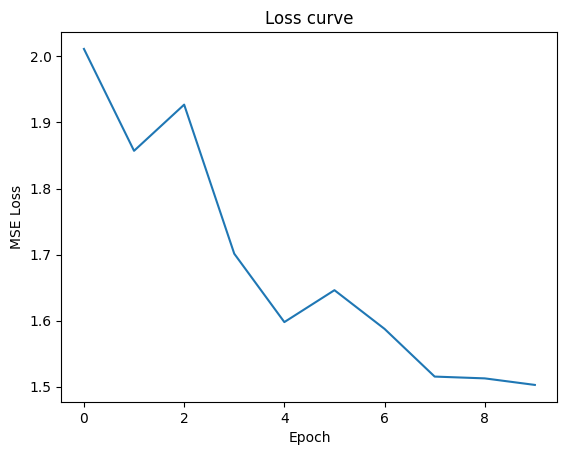

In [46]:
# Plot loss history
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss curve')
plt.show()

In [67]:
def predict_revenue(overview, genre_list, original_language, budget, device):
    inputs = tokenizer.encode_plus(overview, add_special_tokens=True, max_length=256, padding='max_length', truncation=True, return_tensors='pt').to(device)
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    genre_multi_hot = genres_mlb.transform([genre_list])
    genres = torch.tensor(genre_multi_hot, dtype=torch.float).to(device)

    language_one_hot = [0] * len(train_dataset.original_language_cols)
    language_one_hot[train_dataset.original_language_cols.index('original_language_' + original_language)] = 1
    original_language = torch.tensor(language_one_hot, dtype=torch.float).to(device).unsqueeze(0)

    budget = torch.tensor([budget / 1e8], dtype=torch.float).to(device)
    budget_unknown = torch.tensor([budget == 0], dtype=torch.float).to(device)

    # Predict
    with torch.no_grad():
        prediction = model({
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "original_language": original_language,
            "genres": genres,
            "budget": budget,
            "budget_unknown": budget_unknown
        })
    return prediction.item() * 1e8

In [70]:
opp_revenue = predict_revenue(
    "The story of American scientist, J. Robert Oppenheimer, and his role in the development of the atomic bomb.",
    ['Drama', 'History', 'Thriller'],
    'en',
    1e8,
    DEVICE
)
barbie_revenue = predict_revenue(
    "Barbie suffers a crisis that leads her to question her world and her existence.",
    ['Adventure', 'Comedy', 'Fantasy'],
    'en',
    1.45e8,
    DEVICE
)
eeaao_revenue = predict_revenue(
    "A middle-aged Chinese immigrant is swept up into an insane adventure in which she alone can save existence by exploring other universes and connecting with the lives she could have led.",
    ['Action', 'Adventure', 'Comedy'],
    'en',
    25e6,
    DEVICE
)
print("Predicted revenue for Oppenheimer: ", opp_revenue, " USD", "Actual revenue: 1.1 B USD")
print("Predicted revenue for Barbie: ", opp_revenue, " USD", "Actual revenue: 1.44 B USD")
print("Predicted revenue for Everything Everywhere All at Once: ", eeaao_revenue, " USD", "Actual revenue: 140 M USD")

Predicted revenue for Oppenheimer:  129569447.04055786  USD Actual revenue: 1.1 B USD
Predicted revenue for Barbie:  129569447.04055786  USD Actual revenue: 1.44 B USD
Predicted revenue for Everything Everywhere All at Once:  39671638.60797882  USD Actual revenue: 140 M USD


In [43]:
# model.eval()

# def denormalize_revenue(normalized_value):
#     max_revenue = data['revenue'].max()
#     min_revenue = data['revenue'].min()
#     return normalized_value * (max_revenue - min_revenue) + min_revenue
# # 3. Load tokenizer
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# # 4. Test Function
# def predict_revenue(prompt, other_features_input):  # Added other_features_input parameter
#     # Tokenize the input prompt
#     inputs = tokenizer.encode_plus(prompt, add_special_tokens=True, max_length=256, padding='max_length', truncation=True, return_tensors='pt')
#     input_ids = inputs["input_ids"].to(device)
#     attention_mask = inputs["attention_mask"].to(device)

#     # Convert other_features_input to a tensor and make sure it's of size (1, number_of_features)
#     # other_features_tensor = torch.tensor([other_features_input]).to(device)
#     other_features_tensor = torch.tensor([other_features_input], dtype=torch.float).to(device)

#     # Predict
#     with torch.no_grad():
#         prediction = model(input_ids, attention_mask, other_features_tensor)
#     return prediction.item()

# # 5. Test the function
# # prompt = "A romantic story about two star-crossed lovers set in a historical backdrop."
# prompt = "When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys, and other terrifying creatures."

# other_features_for_prompt = [1, 1, 40.9]  # Fill this list with the appropriate feature values for your prompt
# # other_features_for_prompt = torch.tensor([other_features_input], dtype=torch.float).to(device)

# predicted_revenue_normalized = predict_revenue(prompt, other_features_for_prompt)
# predicted_revenue_actual = denormalize_revenue(predicted_revenue_normalized)

# print(f"Predicted revenue for the movie: ${predicted_revenue_actual}")
